# Question 1 

PROBLEM SETUP:
1. Initial wealth = $100
2. Wager amount = $x$
3. Possible outcomes:
    - Win: gain $2x$ ($\text{prob.} = 0.6$)
    - Lose: lose $x$ ($\text{prob.} = 0.4$)
4. Utility function: $U(W) = \log(W)$
$$\text{Expected Utility} = 0.6*\log(100+2x) + 0.4*\log(100-x)$$
5. Constraint: $0 ≤ x ≤ 100$ (cannot wager more than initial wealth)

In [14]:
using JuMP
using Ipopt

w = 100
win_prob = 0.6

mdl1 = Model(Ipopt.Optimizer)
set_silent(mdl1)
@variable(mdl1, 0<=x<=w)
@NLobjective(mdl1, Max, win_prob*log(w+2x) + (1-win_prob)*log(w-x))
optimize!(mdl1)

println("Optimal wager: ",round(value(x), digits=6))
println("Expected utility: ",round(objective_value(mdl1), digits=6))

Optimal wager: 40.0
Expected utility: 4.753512


The optimal wager amount is $x = 40$. By wagering this amount, the expected utility is:

$0.6*\log(100+2*40)+0.4*\log(100-40) \approx 4.7535$

# Question 2


Minimum Variance Portfolio:
Risk: 19.6%
Return: 8.58%
Weights: [39.14, 20.42, 26.54, 3.88, 10.03]%

Tangency Portfolio:
Risk: 23.09%
Return: 10.19%
Weights: [15.95, 0.0, 44.92, 30.14, 9.0]%
Sharpe Ratio: 0.225


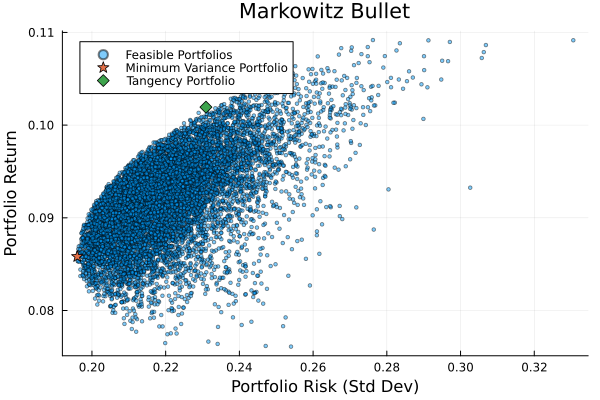

In [15]:
using JuMP
using Ipopt
using LinearAlgebra
using Plots

# Define asset parameters
returns = [0.08, 0.07, 0.10, 0.12, 0.09]  # Expected returns
vols = [0.25, 0.30, 0.28, 0.40, 0.35]     # Volatilities
n_assets = length(returns)

# Construct covariance matrix (30% correlation between all pairs)
Σ = zeros(n_assets, n_assets)
for i in 1:n_assets
    for j in 1:n_assets
        if i == j
            Σ[i,j] = vols[i]^2
        else
            Σ[i,j] = 0.30 * vols[i] * vols[j]
        end
    end
end

# Function to get portfolio return and risk
function portfolio_metrics(weights)
    port_return = dot(weights, returns)
    port_risk = sqrt(weights' * Σ * weights)
    return port_return, port_risk
end

# Generate random portfolios for the feasible set
n_portfolios = 10000
random_ports_risk = Float64[]
random_ports_return = Float64[]

for _ in 1:n_portfolios
    w = rand(n_assets)
    w = w ./ sum(w)  # Normalize to sum to 1
    ret, risk = portfolio_metrics(w)
    push!(random_ports_return, ret)
    push!(random_ports_risk, risk)
end

# Find minimum variance portfolio
model_min_var = Model(Ipopt.Optimizer)
set_silent(model_min_var)
@variable(model_min_var, w[1:n_assets] >= 0)
@constraint(model_min_var, sum(w) == 1)
@objective(model_min_var, Min, w' * Σ * w)
optimize!(model_min_var)
min_var_weights = value.(w)
min_var_return, min_var_risk = portfolio_metrics(min_var_weights)

# Find tangency portfolio (maximum Sharpe ratio)
rf = 0.05  # Risk-free rate
model_tangency = Model(Ipopt.Optimizer)
set_silent(model_tangency)
@variable(model_tangency, w[1:n_assets] >= 0)
@constraint(model_tangency, sum(w) == 1)
@NLobjective(model_tangency, Max, 
    (sum(w[i] * returns[i] for i in 1:n_assets) - rf) / sqrt(sum(w[i] * (Σ[i, j] * w[j]) for i in 1:n_assets, j in 1:n_assets))
)
optimize!(model_tangency)
tangency_weights = value.(w)
tangency_return, tangency_risk = portfolio_metrics(tangency_weights)

# Plot results
p1 = scatter(random_ports_risk, random_ports_return, 
    label="Feasible Portfolios", 
    xlabel="Portfolio Risk (Std Dev)", 
    ylabel="Portfolio Return",
    title="Markowitz Bullet",
    alpha=0.5,
    markersize=2)
scatter!(p1, [min_var_risk], [min_var_return], 
    label="Minimum Variance Portfolio",
    markersize=6,
    markershape=:star)
scatter!(p1, [tangency_risk], [tangency_return], 
    label="Tangency Portfolio",
    markersize=6,
    markershape=:diamond)

# Print results
println("\nMinimum Variance Portfolio:")
println("Risk: ", round(min_var_risk * 100, digits=2), "%")
println("Return: ", round(min_var_return * 100, digits=2), "%")
println("Weights: ", round.(min_var_weights * 100, digits=2), "%")

println("\nTangency Portfolio:")
println("Risk: ", round(tangency_risk * 100, digits=2), "%")
println("Return: ", round(tangency_return * 100, digits=2), "%")
println("Weights: ", round.(tangency_weights * 100, digits=2), "%")
println("Sharpe Ratio: ", round((tangency_return - rf) / tangency_risk, digits=3))

display(p1)

# Question 3

In [16]:
# Option Valuation Example

# Given parameters
S0 = 10.0           # Current stock price
K = 10.50           # Strike price
T = 0.25            # Time to maturity (3 months = 0.25 years)
r = 0.04            # Annual risk-free rate
Su = 11.0           # Up state price
Sd = 9.0            # Down state price

# Calculate option payoffs in each state
Cu = max(Su - K, 0)  # Up state payoff
Cd = max(Sd - K, 0)  # Down state payoff

println("\nOption Valuation for 3-month 10.50 Call")
println("----------------------------------------")

# Method 1: Hedging Approach
Δ = (Cu - Cd)/(Su - Sd)  # Hedge ratio
B = (Su*Cd - Sd*Cu)/(Su - Sd)/exp(r*T)  # Bond position
option_value_hedging = Δ*S0 + B

println("\n1. Hedging Method")
println("Hedge ratio (Δ): ", round(Δ, digits=4))
println("Bond position (B): ", round(B, digits=4))
println("Option value: \$", round(option_value_hedging, digits=4))

# Method 2: Risk-Neutral Probabilities
p_star = (exp(r*T)*S0 - Sd)/(Su - Sd)  # Risk-neutral probability of up state
option_value_rn = exp(-r*T)*(p_star*Cu + (1-p_star)*Cd)

println("\n2. Risk-Neutral Expectation Method")
println("Risk-neutral probability (p*): ", round(p_star, digits=4))
println("Option value: \$", round(option_value_rn, digits=4))

# Method 3: Arrow-Debreu State Prices
qu = p_star*exp(-r*T)  # State price for up state
qd = (1-p_star)*exp(-r*T)  # State price for down state
option_value_ad = qu*Cu + qd*Cd

println("\n3. Arrow-Debreu State Pricing Method")
println("Up state price (qu): ", round(qu, digits=4))
println("Down state price (qd): ", round(qd, digits=4))
println("Option value: \$", round(option_value_ad, digits=4))

# Verify all methods give same result
println("\nVerification: All methods yield same value ≈ \$", round(option_value_hedging, digits=4))



Option Valuation for 3-month 10.50 Call
----------------------------------------

1. Hedging Method
Hedge ratio (Δ): 0.25
Bond position (B): -2.2276
Option value: $0.2724

2. Risk-Neutral Expectation Method
Risk-neutral probability (p*): 0.5503
Option value: $0.2724

3. Arrow-Debreu State Pricing Method
Up state price (qu): 0.5448
Down state price (qd): 0.4453
Option value: $0.2724

Verification: All methods yield same value ≈ $0.2724


# Question 4


Expected-Log Optimal Portfolio:
Weights: [0.1675, 0.0, 0.446, 0.2953, 0.0912]
Expected Return: 0.1016
Risk: 0.2296
Sharpe Ratio: 0.2249


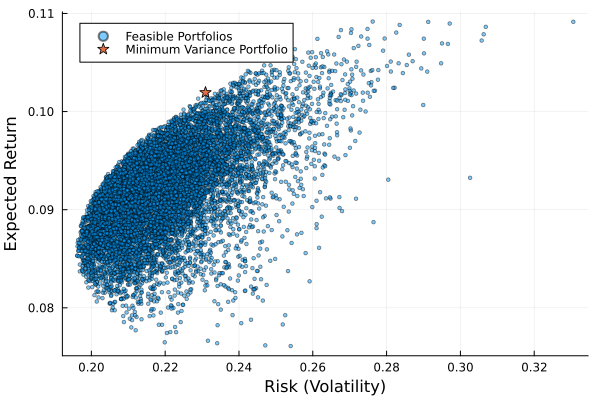

In [17]:
# Find Expected-Log optimal portfolio
model_log = Model(Ipopt.Optimizer)
set_silent(model_log)
@variable(model_log, w_log[1:n_assets] >= 0)
@constraint(model_log, sum(w_log) == 1)

# Objective: maximize mean - 0.5*variance
@objective(model_log, Max, 
    dot(w_log, returns) - 0.5 * (w_log' * Σ * w_log))

optimize!(model_log)

# Get optimal weights and metrics
log_weights = value.(w_log)
log_return, log_risk = portfolio_metrics(log_weights)

println("\nExpected-Log Optimal Portfolio:")
println("Weights: ", round.(log_weights, digits=4))
println("Expected Return: ", round(log_return, digits=4))
println("Risk: ", round(log_risk, digits=4))
println("Sharpe Ratio: ", round((log_return - 0.05)/log_risk, digits=4))

# Plot results
p1 = scatter(random_ports_risk, random_ports_return, 
    label="Feasible Portfolios",
    xlabel="Risk (Volatility)",
    ylabel="Expected Return",
    alpha=0.5,
    markersize=2)

# Add minimum variance portfolio
min_var_weights = value.(w)
min_var_return, min_var_risk = portfolio_metrics(min_var_weights)
scatter!(p1, [min_var_risk], [min_var_return],
    label="Minimum Variance Portfolio",
    markersize=6,
    markershape=:star)



# Question 5

In [18]:
# === 1. Setup ===
S0 = 10.0                           # Current stock price
r  = 0.04                           # Annual risk-free rate
T  = 0.25                           # 3 months in years
R  = exp(r * T)                     # Risk-free growth factor over T

# Possible terminal stock prices in 3 months:
Su, Sm, Sd = 11.70, 10.00, 8.30

# Observed market info for the 10.50 call
K_known    = 10.50
C_known    = 0.24    # Observed market price
payoff_u   = max(Su - K_known, 0)   # 11.70 - 10.50 = 1.20
payoff_m   = max(Sm - K_known, 0)   # 10.00 - 10.50 = 0 => 0
payoff_d   = max(Sd - K_known, 0)   #  8.30 - 10.50 = -2.20 => 0

# === 2. Solve for Risk-Neutral Probabilities p_u, p_m, p_d ===
# We have three unknowns (p_u, p_m, p_d) and three equations:
#   (1) p_u + p_m + p_d = 1
#   (2) R * S0 = p_u*Su + p_m*Sm + p_d*Sd
#   (3) R * C_known = p_u*payoff_u + p_m*payoff_m + p_d*payoff_d

using LinearAlgebra

# Build the system A * p = b, where p = [p_u, p_m, p_d].
A = [
    1.0      1.0      1.0;        # (1)
    Su       Sm       Sd;         # (2) but not multiplied by R here, we'll handle that
    payoff_u payoff_m payoff_d    # (3) similarly
]
b = [
    1.0;
    R * S0;             # Must match R*S0
    R * C_known         # Must match R*C_known
]

# Solve the linear system. 
# We'll do it carefully because we have 3 eqns but it's not always guaranteed to invert nicely.
p = A \ b
p_u, p_m, p_d = p

println("=== Risk-Neutral Probabilities (3-State) ===")
println("p_u = ", p_u)
println("p_m = ", p_m)
println("p_d = ", p_d)

# Check they sum to 1, etc.
println("Sum of p's = ", p_u + p_m + p_d)

# 3. Price the 9.50 call using these probabilities 
K_new     = 9.50
payoff_u2 = max(Su - K_new, 0)     # e.g. 11.70 - 9.50 = 2.20
payoff_m2 = max(Sm - K_new, 0)     # e.g. 10.00 - 9.50 = 0.50
payoff_d2 = max(Sd - K_new, 0)     # e.g.  8.30 - 9.50 = -1.20 => 0

# Fair price = (1/R) * [p_u * payoff_u2 + p_m * payoff_m2 + p_d * payoff_d2]
C_new = (p_u*payoff_u2 + p_m*payoff_m2 + p_d*payoff_d2) / R

println("\n=== Implied Price of 9.50 Call ===")
println("Call(9.50) = ", C_new)



=== Risk-Neutral Probabilities (3-State) ===
p_u = 0.20201003341683382
p_m = 0.6550985630732029
p_d = 0.1428914035099633
Sum of p's = 1.0

=== Implied Price of 9.50 Call ===
Call(9.50) = 0.7642901117299722
